# Liu Xingyu - DAV 6150 - Module 2 assignment

## Introduction

In this report, I will analyze on a data set consisting of 4 features which could influence gas turbine's net hourly electrical energy output to construct two linear regression models using K-Fold cross validation. 

To accomplish this, I will perform some basic exploratory data analysis (EDA), derive insights from my statistical analysis of the attributes and the accompanying exploratory graphics I create. Evaluate which explanatory variables appear to be relatively more “predictive” of the response variable, select appropriate statistical metrics to be calculated.

Also, I will construct two different linear regression models that predict net 
hourly electrical energy output based on the provided explanatory variables and evaluate them using 
K-fold cross validation. Each of my models will include at least 2 explanatory variables. After executing my K-fold cross validation for each of my models, I will select my preferred model based on the average accuracy scores I derived via the K-fold process.

## Data Profiling & Domain Knowledge Development

Reference from [here](https://rstudio-pubs-static.s3.amazonaws.com/345459_736f15de86c949978f33ed4348c7fae4.html):

A gas turbine generator generates electricity and waste heat is used to make steam to generate additional electricity via a steam turbine. More recently, as simple cycle efficiencies have improved and as natural gas prices have fallen, gas turbines have been more widely adopted for base load power generation, especially in combined cycle mode, where waste heat is recovered in waste heat boilers, and the steam used to produce additional electricity.

The basic principle of the Combined Cycle is simple: burning gas in a gas turbine (GT) produces not only power - which can be converted to electric power by a coupled generator - but also fairly hot exhaust gases. Routing these gases through a water-cooled heat exchanger produces steam, which can be turned into electric power with a coupled steam turbine and generator. This type of power plant is being installed in increasing numbers round the world where there is access to substantial quantities of natural gas.

Features consist of hourly average ambient variables：

**T** - Temperature (T) in the range 1.81°C and 37.11°C,

**V** - Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg

**AP** - Ambient Pressure (AP) in the range 992.89-1033.30 milibar

**RH** - Relative Humidity (RH) in the range 25.56% to 100.16%

**EP** - Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

## Exploratory Data Analysis

First I will read the data into python using pandas read csv function from Github Repository. Then I will look for missing and/or invalid data values and perform an exploratory data analysis on my dataset to determine what data need to be prepared. 

In [288]:
#first import the necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#next read in the file
filename = 'https://raw.githubusercontent.com/Bella1025/DAV6150./master/M2_Data%20(2).csv'
electricity = pd.read_csv(filename)

#check results
electricity.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [289]:
## Check the types of the data
electricity.dtypes

T     float64
V     float64
AP    float64
RH    float64
EP    float64
dtype: object

From above, I could see that: Temperature (T), Exhaust Vacuum (V), Ambient Pressure (AP) and Net hourly electrical energy output (EP) are all numeric variables.

In [290]:
# check the dataset for null values
electricity.isnull().sum()

T     0
V     0
AP    0
RH    0
EP    0
dtype: int64

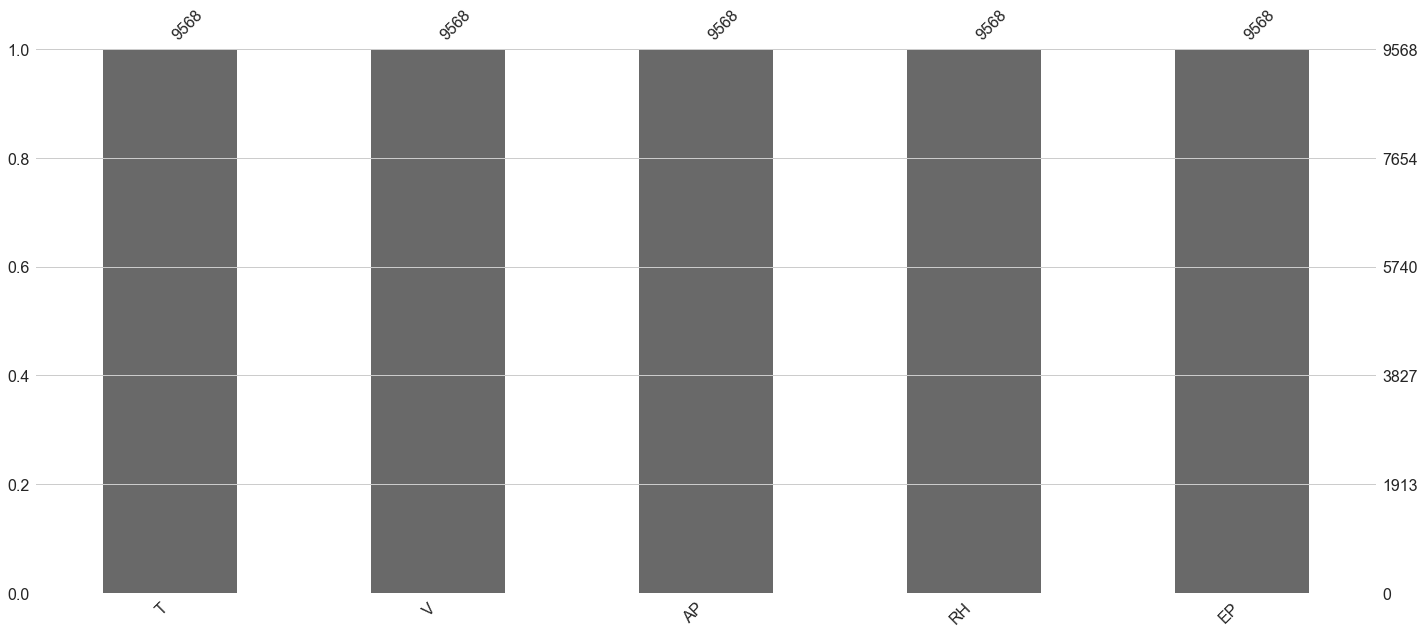

In [291]:
#first import missingno after pip install
import missingno as msno

#visualize the amount of missing data using missingno's bar chart
msno.bar(electricity);

I see there are no missing values in the data set.

In [292]:
#get summary statistics for each variable, including mean, standard deviation, median, quartiles, and range
electricity.describe()

,T,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


I see from above that the range of Temperature (T), Exhaust Vacuum (V), Ambient Pressure (AP), Relative Humidity (RH), Net hourly electrical energy output (EP) do not contain negative values. From my domain knowledge and research, there should not be negative values for these attributes. 

So there is no need to deal with negative values.

The mean value of Temperature (T) is 19.651231, the mean value of Exhaust Vacuum (V) is 54.305804, the mean value of Ambient Pressure (AP) is 1013.259078, the mean value of Relative Humidity (RH) is 73.308978, the mean value of Net hourly electrical energy output (EP) is 454.365009. The mean values of Ambient Pressure (AP) is much higher than other variables. So the data need to be normalized or standarized, I will demonstrate further to show how I will deal with the large range data.

Next I will look at the distributions of my data to identify the shape of the distribution as well as identify any potential outliers.

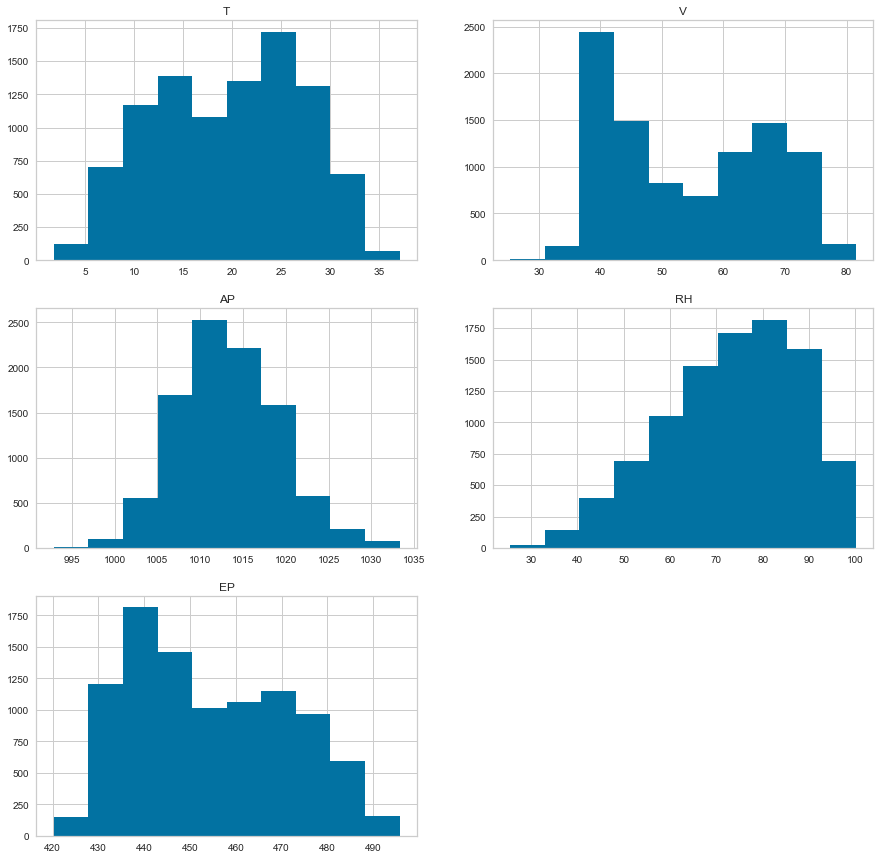

In [293]:
#ignore warnings
np.warnings.filterwarnings('ignore')

plt.figure(figsize=(15,15))

i=1
columns=electricity.columns.tolist()
for k in columns[0:] :  
    plt.subplot(3,2,i) 
    plt.hist(electricity[k])
    plt.title('%s' %k)
    i=i+1

#show results    
plt.show()

From the histograms, I found the variable Ambient Pressure (AP) is almost normally distributed, Relative Humidity (RH) is almost skewed distributed, the distributions of other variables are of no pattern. 

Next I will look at boxplots of my data.

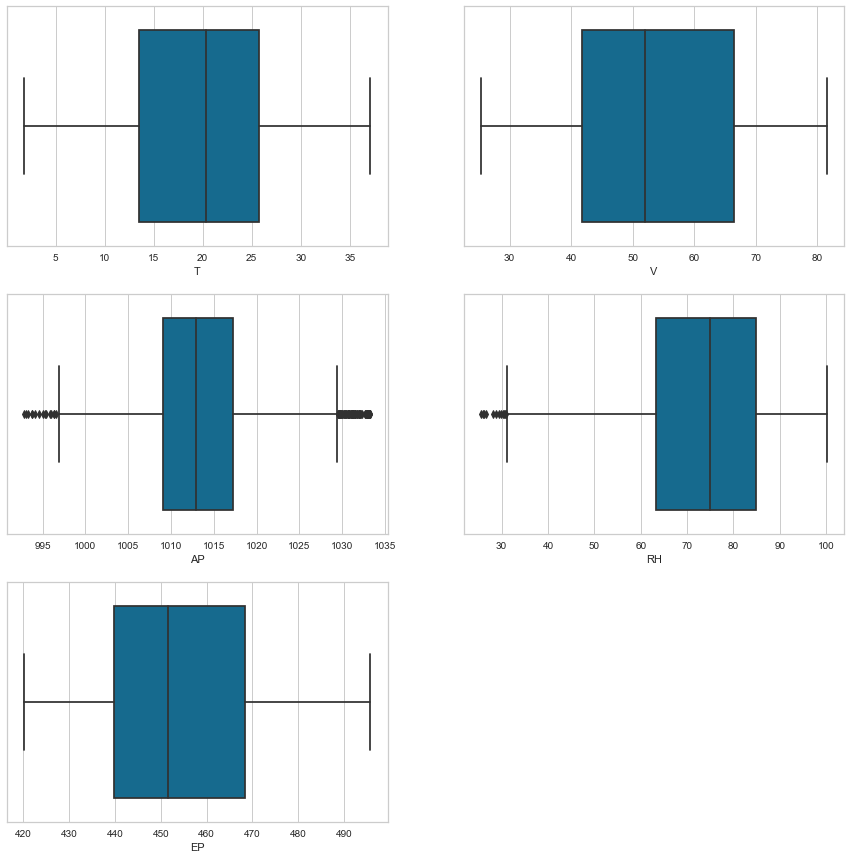

In [294]:
plt.figure(figsize=(15,15))

i=1
columns=electricity.columns.tolist()
for k in columns[0:] :  
    plt.subplot(3,2,i) 
    sns.boxplot(x=k,data=electricity)
    i=i+1 

#show results
plt.show()

From the boxplots, I could see the variable Ambient Pressure (AP) and Relative Humidity (RH) have lots of data out of normal range, while the variable Temperature (T), Exhaust Vacuum (V) and Net hourly electrical energy output (EP) do not. 

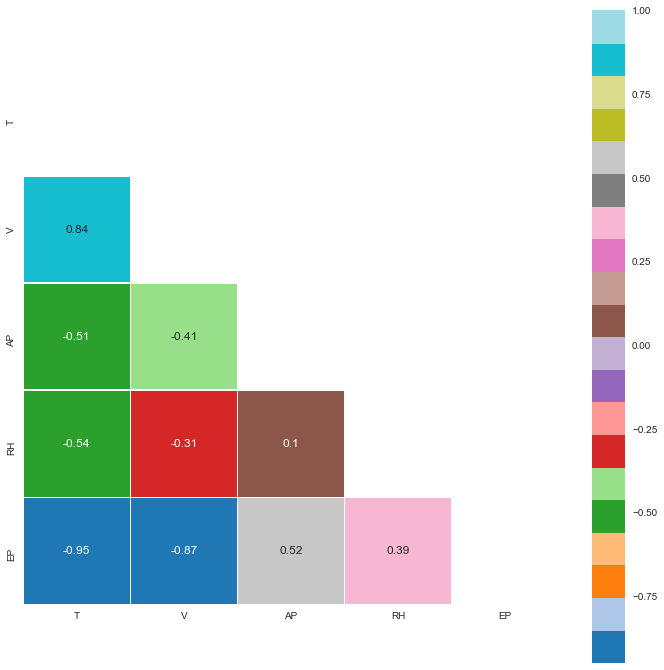

In [295]:
cor_matrix = electricity.corr()
mask = np.zeros_like(cor_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (12, 12))
#Draw the heatmap with the mask and correct aspect ratio, mask=True, upper triangular will be hide
sns.heatmap(cor_matrix, mask=mask,
            square = True, linewidths = .5, ax = ax, cmap = "tab20",annot=True)

I see from the correlation heatmap that:

- The Strongest correlation is between Temperature (T) and Net hourly electrical energy output (EP), which is a negative correlation of 0.95.

- The second strong correlation is between Exhaust Vacuum (V) and Net hourly electrical energy output (EP), which is a negative correlation of 0.87.

- The third strong correlation is between Temperature (T) and Net hourly electrical energy output (EP), which is a positive correlation of 0.84.

Except those, other attributes do not have a particularly strong correlation. 

Next, I will look at the amount of invalid values with domain knowledge in five variables.

In [296]:
electricity2 = electricity.copy()
#look at number of invalid values in the variable Temperature(T)
electricity2['InvalidT'] = (electricity['T'] > 37.11) & (electricity['T'] < 1.81)
sum(electricity2['InvalidT'])

0

In [297]:
#look at number of invalid values in the variable Exhaust Vacuum (V) 
electricity2['InvalidV'] = (electricity['V'] > 81.56) & (electricity['T'] < 25.36)
sum(electricity2['InvalidV'])

0

In [298]:
#look at number of invalid values in the variable Ambient Pressure (AP)
electricity2['InvalidAP'] = (electricity['AP'] > 1033.30) & (electricity['AP'] < 992.89)
sum(electricity2['InvalidAP'])

0

In [299]:
#look at number of invalid values in the variable Relative Humidity (RH)
electricity2['InvalidRH'] = (electricity['RH'] > 100.16) & (electricity['RH'] < 25.56)
sum(electricity2['InvalidRH'])

0

In [300]:
#look at number of invalid values in the variable Net hourly electrical energy output (EP)
electricity2['InvalidEP'] = (electricity['EP'] > 495.76) & (electricity['EP'] < 420.26)
sum(electricity2['InvalidEP'])

0

### Temporary Conclusion after Exploratory Data Analysis:

1. There are no missing values in the data set.
2. There are no negative values in the data set.
3. The variables in the dataset are of large range, which need to be normalized or standarized.
4. The variable Ambient Pressure (AP) is normally distributed, the variable Relative Humidity (RH) is skewed distributed, the distributions of other variables are of no pattern.
5. The variables Ambient Pressure (AP) and Relative Humidity (RH) have lots of data not in normal range, while the variable Temperature (T), Exhaust Vacuum (V) and Net hourly electrical energy output (EP) do not.
6. Temperature (T) and Exhaust Vacuum (V) have strong positive correlation, Net hourly electrical energy output (EP) and Exhaust Vacuum (V) have strong negative correlation, Net hourly electrical energy output (EP) and Temperature (T) have strong negative correlation. The correlation between Net hourly electrical energy output (EP) and Temperature (T) is strongest. 
7. All the variables are in the given range in the domain knowledge. 

Next I will plot some scatter plots:

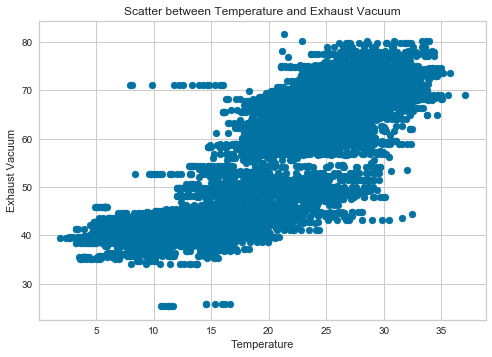

In [301]:
## Scatter plots between Temperature and Exhaust Vacuum
x = electricity['T']
y = electricity['V']
plt.scatter(x,y)
plt.title('Scatter between Temperature and Exhaust Vacuum')
plt.xlabel('Temperature')
plt.ylabel('Exhaust Vacuum')
plt.show()

There is no linear relationship between Temperature and Exhaust Vacuum, but there is a positive tendency in clustering, with higher Temperature, the Exhaust Vacuum is higher.

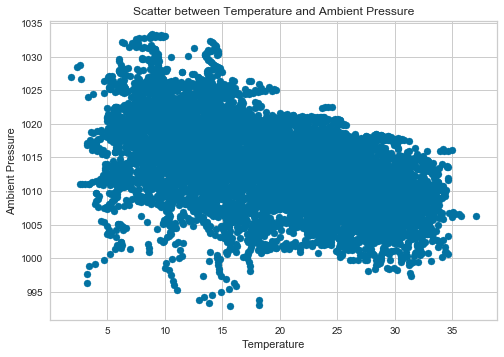

In [302]:
## Scatter plots between Temperature and Ambient Pressure
x = electricity['T']
y = electricity['AP']
plt.scatter(x,y)
plt.title('Scatter between Temperature and Ambient Pressure')
plt.xlabel('Temperature')
plt.ylabel('Ambient Pressure')
plt.show()

There is no linear relationship between Temperature and Ambient Pressure, but there is a negative tendency in clustering, with higher Temperature, the Ambient Pressure is lower.

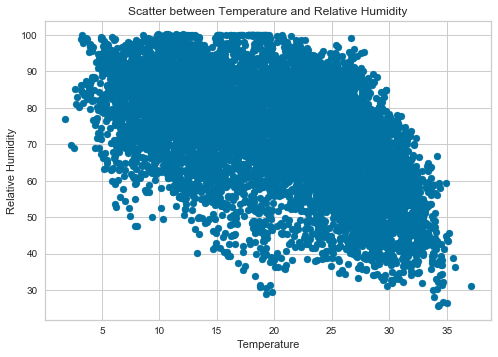

In [303]:
## Scatter plots between Temperature and Relative Humidity
x = electricity['T']
y = electricity['RH']
plt.scatter(x,y)
plt.title('Scatter between Temperature and Relative Humidity')
plt.xlabel('Temperature')
plt.ylabel('Relative Humidity')
plt.show()

There is no linear relationship between Temperature and Relative Humidity, but there is a negative tendency in clustering, with higher Temperature, the Relative Humidity is lower. High temperature makes water evaporate readily, make humidity down, so this is reasonable.

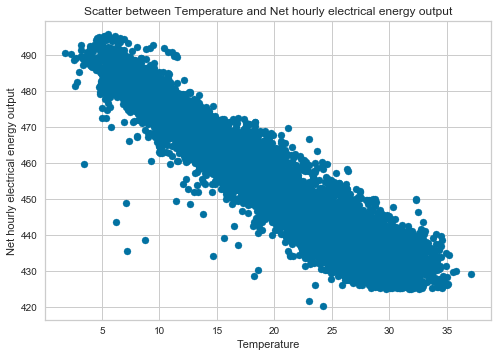

In [304]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['T']
y = electricity['EP']
plt.scatter(x,y)
plt.title('Scatter between Temperature and Net hourly electrical energy output')
plt.xlabel('Temperature')
plt.ylabel('Net hourly electrical energy output')
plt.show()

There seems a negative linear relationship between Temperature and Net hourly electrical energy output. With Temperature higher, Net hourly electrical energy output is lower.

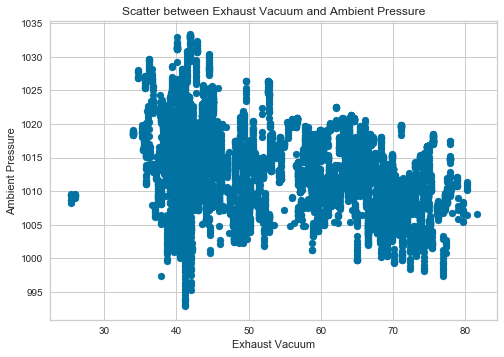

In [305]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['V']
y = electricity['AP']
plt.scatter(x,y)
plt.title('Scatter between Exhaust Vacuum and Ambient Pressure')
plt.xlabel('Exhaust Vacuum')
plt.ylabel('Ambient Pressure')
plt.show()

There is no linear relationship between Exhaust Vacuum and Ambient Pressure, also no tendency. 

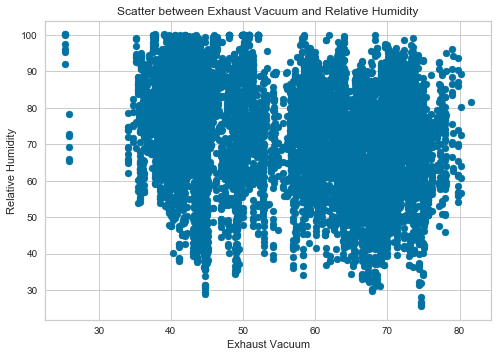

In [306]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['V']
y = electricity['RH']
plt.scatter(x,y)
plt.title('Scatter between Exhaust Vacuum and Relative Humidity')
plt.xlabel('Exhaust Vacuum')
plt.ylabel('Relative Humidity')
plt.show()

There is no linear relationship between Exhaust Vacuum and Relative Humidity, also no tendency.

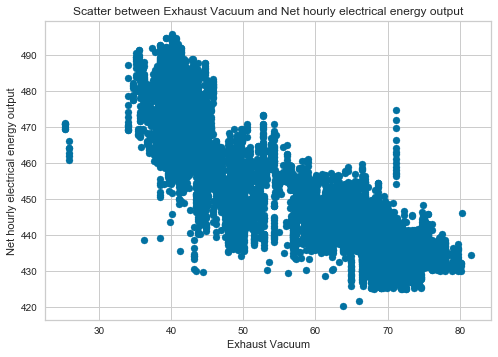

In [307]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['V']
y = electricity['EP']
plt.scatter(x,y)
plt.title('Scatter between Exhaust Vacuum and Net hourly electrical energy output')
plt.xlabel('Exhaust Vacuum')
plt.ylabel('Net hourly electrical energy output')
plt.show()

There seems a negative tendency between Exhaust Vacuum and Net hourly electrical energy output, with Exhaust Vacuum higher, Net hourly electrical energy output is lower.

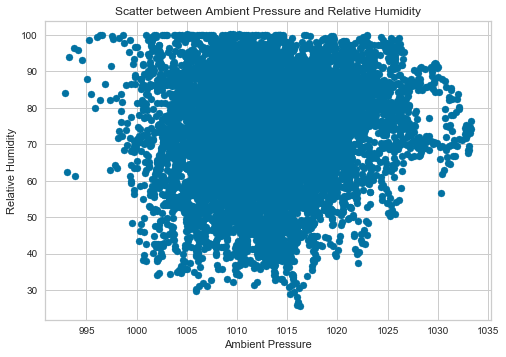

In [308]:
## Scatter plots between Temperature and Relative Humidity
x = electricity['AP']
y = electricity['RH']
plt.scatter(x,y)
plt.title('Scatter between Ambient Pressure and Relative Humidity')
plt.xlabel('Ambient Pressure')
plt.ylabel('Relative Humidity')
plt.show()

There seems no relationships and no tendency between Ambient Pressure and Relative Humidity.

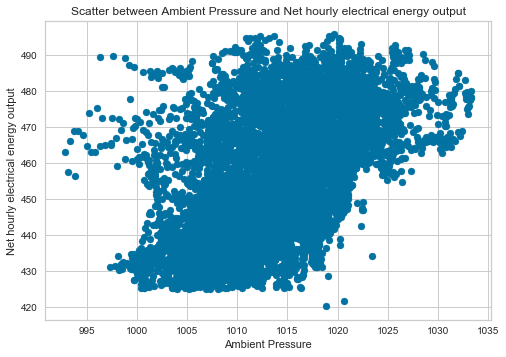

In [309]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['AP']
y = electricity['EP']
plt.scatter(x,y)
plt.title('Scatter between Ambient Pressure and Net hourly electrical energy output')
plt.xlabel('Ambient Pressure')
plt.ylabel('Net hourly electrical energy output')
plt.show()

There is no linear relationship between Ambient Pressure and Net hourly electrical energy output, a little positive tendency.

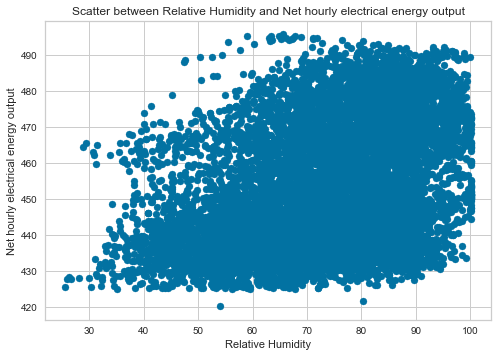

In [310]:
## Scatter plots between Temperature and Net hourly electrical energy output
x = electricity['RH']
y = electricity['EP']
plt.scatter(x,y)
plt.title('Scatter between Relative Humidity and Net hourly electrical energy output')
plt.xlabel('Relative Humidity')
plt.ylabel('Net hourly electrical energy output')
plt.show()

There is no relationship and tendency between Relative Humidity and Net hourly electrical energy output.

### Temporary Conclusion after Scatter Plots:

1. Some pairs of data have some positive or negative tendency in their clustering points, such as, Temperature and Exhaust Vacuum, Temperature and Net hourly electrical energy output, Exhaust Vacuum and Net hourly electrical energy output.

2. The only relationship which is approximate to linear relationship are between Temperature and Net hourly electrical energy output.

Based on exploratory data analysis, Temperature and Exhaust Vacuum seems the best explanatory variables for linear regression models.

## Data Preparation and EDA Review 

My idea to handle the large range of data is to standardize them. Because normalization is to rescale numeric attributes into the range 0 and 1, standardization is to shift the distribution of each attribute to mean zero and a standard deviation of one. I think let the numeric data have same mean and standard deviation is convenient to compare their histograms after transforming, so let me start it:

In [311]:
from sklearn import preprocessing
standardized_electricity = preprocessing.scale(electricity)

In [312]:
# Convert the array to dataframe
standardized_electricity = pd.DataFrame(standardized_electricity)

In [313]:
## Show converted dataframe
standardized_electricity

,0,1,2,3,4
0,-0.629519,-0.987297,1.820488,-0.009519,0.521208
1,0.741909,0.681045,1.141863,-0.974621,-0.585664
2,-1.951297,-1.173018,-0.185078,1.289840,2.003679
3,0.162205,0.237203,-0.508393,0.228160,-0.462028
4,-1.185069,-1.322539,-0.678470,1.596699,1.144666
...,...,...,...,...,...
9563,-0.402737,-0.363242,0.126450,1.211755,0.331944
9564,-0.867037,-1.190331,1.753131,-0.447205,0.893877
9565,1.565840,1.575811,-0.057099,-2.522618,-1.452881
9566,0.647976,1.191778,0.101191,-0.747901,-1.091345


In [314]:
## Add names for converted dataframe
standardized_electricity.columns = ['Temperature(T)','Exhaust Vacuum (V)','Ambient Pressure (AP)',
                                    'Relative Humidity (RH)','Net hourly electrical energy output (EP)']

In [315]:
## Show dataframe
standardized_electricity

,Temperature(T),Exhaust Vacuum (V),Ambient Pressure (AP),Relative Humidity (RH),Net hourly electrical energy output (EP)
0,-0.629519,-0.987297,1.820488,-0.009519,0.521208
1,0.741909,0.681045,1.141863,-0.974621,-0.585664
2,-1.951297,-1.173018,-0.185078,1.289840,2.003679
3,0.162205,0.237203,-0.508393,0.228160,-0.462028
4,-1.185069,-1.322539,-0.678470,1.596699,1.144666
...,...,...,...,...,...
9563,-0.402737,-0.363242,0.126450,1.211755,0.331944
9564,-0.867037,-1.190331,1.753131,-0.447205,0.893877
9565,1.565840,1.575811,-0.057099,-2.522618,-1.452881
9566,0.647976,1.191778,0.101191,-0.747901,-1.091345


Plot the histograms again to see whether my standardization changed the shape of distributions.

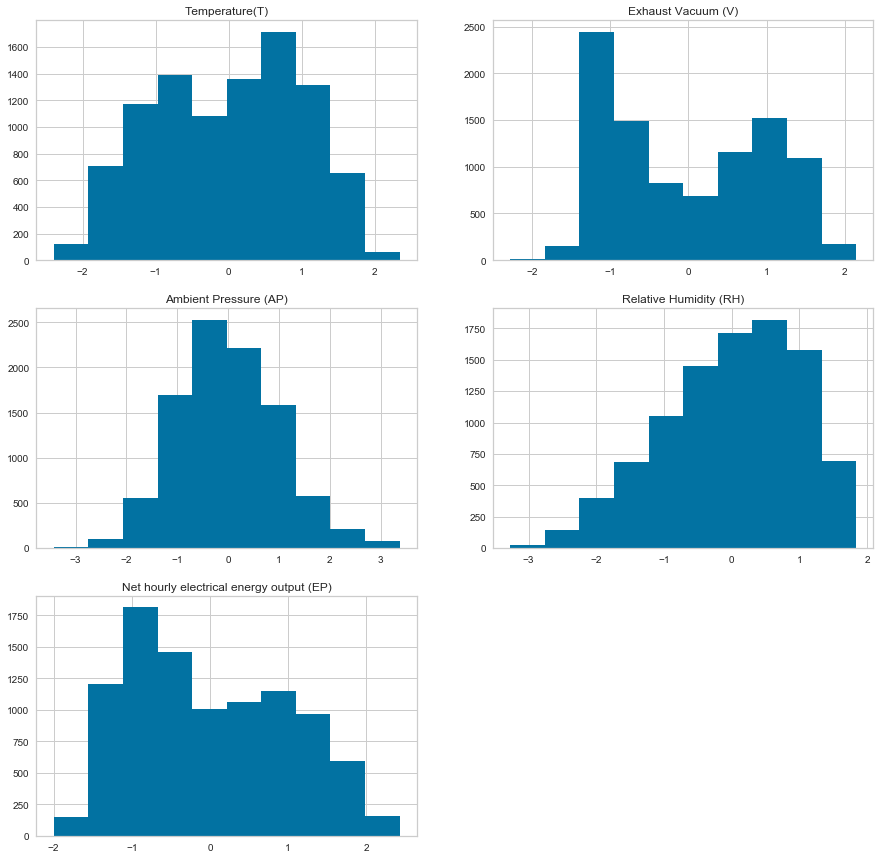

In [316]:
#ignore warnings
np.warnings.filterwarnings('ignore')

plt.figure(figsize=(15,15))

i=1
columns=standardized_electricity.columns.tolist()
for k in columns[0:] :  
    plt.subplot(3,2,i) 
    plt.hist(standardized_electricity[k])
    plt.title('%s' %k)
    i=i+1

#show results    
plt.show()

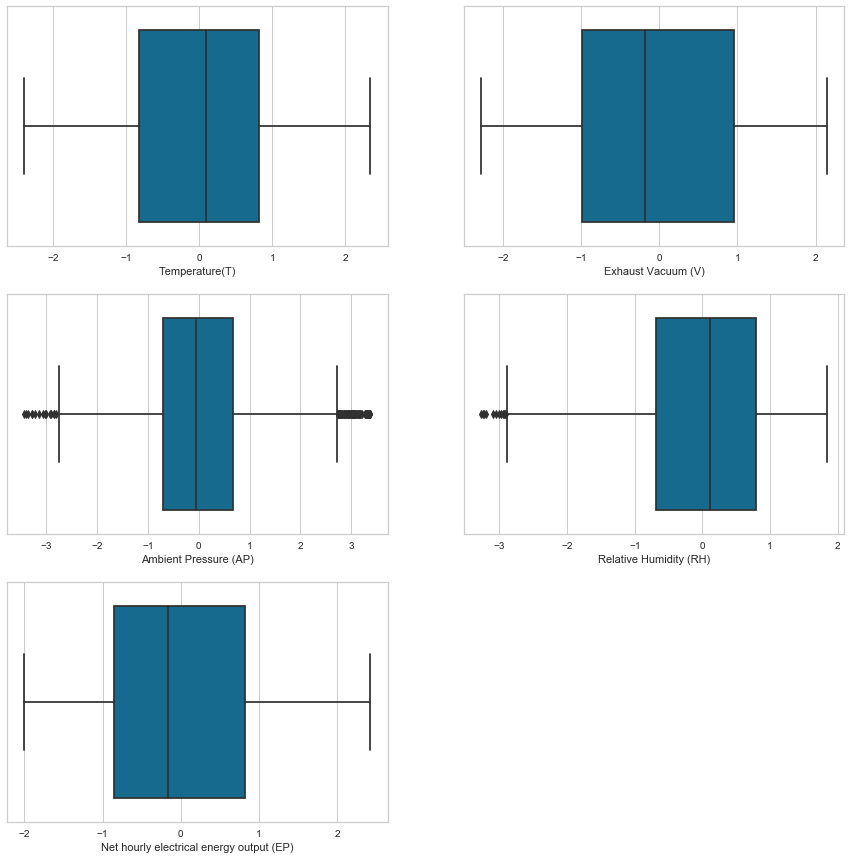

In [317]:
plt.figure(figsize=(15,15))

i=1
columns=standardized_electricity.columns.tolist()
for k in columns[0:] :  
    plt.subplot(3,2,i) 
    sns.boxplot(x=k,data=standardized_electricity)
    i=i+1 

#show results
plt.show()

No change happened.

For the data out of range, since there are seldom, I decide not to remove or replace them.

## Feature selection

### Wrapper method: 

Reference link: [here](https://stackabuse.com/applying-wrapper-methods-in-python-for-feature-selection/) and [there](https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f)

Advantages of Wrapper method: wrapper methods can find the best set of features for a specific algorithm

Disadvantage of Wrapper method: these set of features may not be optimal for every other machine learning algorithm

### 1. Step forward feature selection

In [318]:
import statsmodels.api as sm
## Define a forward selection function
def forward_selection(data,target,significance_level = 0.05):
    initialfeatures = data.columns.tolist()
    bestfeatures = []
    while (len(initialfeatures)>0):
        remainingfeatures = list(set(initialfeatures)-set(bestfeatures))
        new_pvalue = pd.Series(index = remainingfeatures)
        for new_column in remainingfeatures:
            model = sm.OLS(target,sm.add_constant(data[bestfeatures+[new_column]])).fit()
            new_pvalue[new_column] = model.pvalues[new_column]
        min_p_value = new_pvalue.min()
        if (min_p_value < significance_level):
            bestfeatures.append(new_pvalue.idxmin())
        else:
         break
    return bestfeatures

The functions returns the final list of significant features based on p-values through forward selection.

In [319]:
forward_selection(standardized_electricity,standardized_electricity['Net hourly electrical energy output (EP)'])

['Relative Humidity (RH)',
 'Temperature(T)',
 'Net hourly electrical energy output (EP)',
 'Ambient Pressure (AP)',
 'Exhaust Vacuum (V)']

The terrible thing is, the step forward feature selection say all the features are significant, next, I will use correlation heatmap again to choose features.

### 2. Correlation heatmap selection

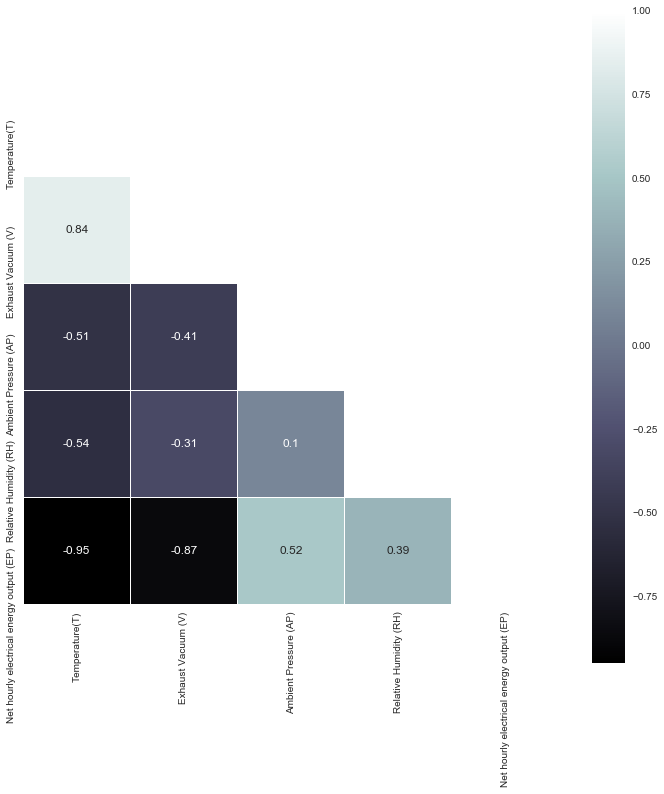

In [320]:
cor_matrix = standardized_electricity.corr()
mask = np.zeros_like(cor_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (12, 12))
#Draw the heatmap with the mask and correct aspect ratio, mask=True, upper triangular will be hide
sns.heatmap(cor_matrix, mask=mask,
            square = True, linewidths = .5, ax = ax, cmap = "bone",annot=True)

From correlation heatmap, the variables which have strongest correlations with Net hourly electrical energy output(EP) are Temperature(T) and Exhaust Vacuum. 

## Modeling 

I will construct two linear regression models using two sets of explanatory variables selected above:

- Relative Humidity (RH), Temperature(T), Ambient Pressure (AP), Exhaust Vacuum (V)
- Temperature(T), Exhaust Vacuum (V)

### Model 1 - Linear regression model with features:

- Relative Humidity (RH)
- Temperature(T)
- Ambient Pressure (AP)
- Exhaust Vacuum (V)

In [321]:
X = standardized_electricity[['Relative Humidity (RH)','Temperature(T)','Ambient Pressure (AP)','Exhaust Vacuum (V)']].values
y = standardized_electricity['Net hourly electrical energy output (EP)'].values

#### How to choose ideal value of k? According to [here](https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation):

"If possible, I use a 𝑘 that is a divisor of the sample size, or the size of the groups in the sample that should be stratified.

Too large 𝑘 mean that only a low number of sample combinations is possible, thus limiting the number of iterations that are different."

I would choose a k that is a divisor of the sample size and not large.

Calculate the sample size:

In [322]:
standardized_electricity.shape

(9568, 5)

Since the sample are of 9568 rows, I think k = 2 is a best choice, go through experiments and trials, it is really a best choice:

In [323]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
kf.get_n_splits(X)

2

In [324]:
for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

TRAIN: [4784 4785 4786 ... 9565 9566 9567] TEST: [   0    1    2 ... 4781 4782 4783]
TRAIN: [   0    1    2 ... 4781 4782 4783] TEST: [4784 4785 4786 ... 9565 9566 9567]


### Apply Linear Regression model to the split data

#### Step 1: Import the model I want to use

In [325]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()  
regr.fit(X_train, y_train)

LinearRegression()

#### Step 2: To see the value of the intercept and slope calculated by the linear regression algorithm:

In [326]:
#To retrieve the intercept:
print(regr.intercept_)
#For retrieving the slope:
print(regr.coef_)

-0.0015067365809931883
[-0.14310867 -0.87408838  0.0225849  -0.16640703]


#### Step 3: Training the model on the data, predict the value:

In [327]:
y_pred = regr.predict(X_test)

#### Now compare the actual output values for y_test with the predicted values:

In [328]:
from sklearn import metrics
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison.head(25)

,Actual,Predicted
0,-0.498357,-0.398281
1,-0.612618,-0.626174
2,-1.192716,-1.194326
3,-0.586836,-0.690691
4,-1.401316,-1.352451
5,-0.751490,-0.557014
6,-1.436474,-1.457540
7,-1.550149,-1.085321
8,1.374361,0.983158
9,0.597968,0.856298


#### Visualize comparison result as a bar graph using the below script :

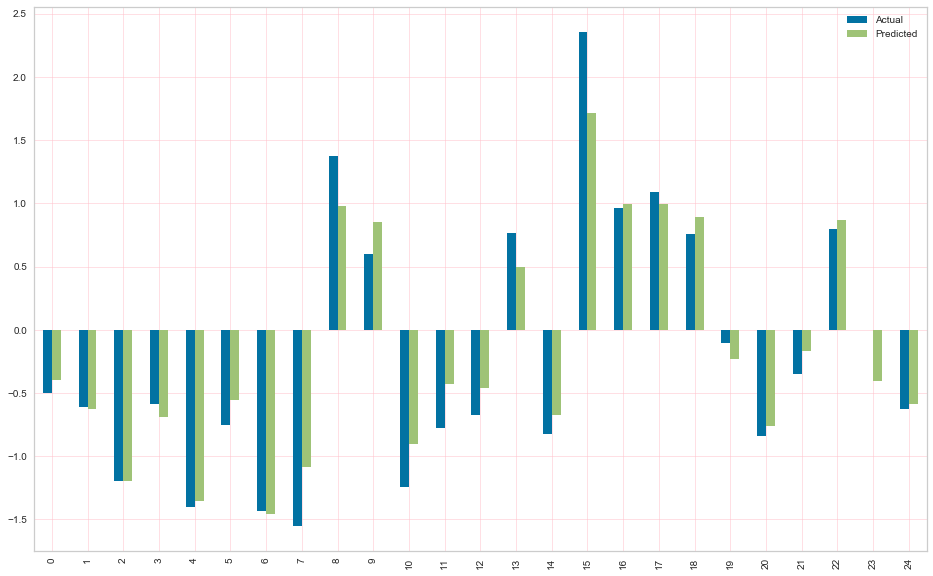

In [329]:
df1 = comparison.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='pink')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [330]:
regr.score(X_train, y_train)

0.9291242333448995

### Model 2 - Linear regression model with features:

- Temperature(T)
- Exhaust Vacuum (V)

In [331]:
X = standardized_electricity[['Temperature(T)','Exhaust Vacuum (V)']].values
y = standardized_electricity['Net hourly electrical energy output (EP)'].values

In [332]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
kf.get_n_splits(X)

2

In [333]:
for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

TRAIN: [4784 4785 4786 ... 9565 9566 9567] TEST: [   0    1    2 ... 4781 4782 4783]
TRAIN: [   0    1    2 ... 4781 4782 4783] TEST: [4784 4785 4786 ... 9565 9566 9567]


### Apply Linear Regression model to the split data

#### Step 1: Import the model I want to use

In [334]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()  
regr.fit(X_train, y_train)

LinearRegression()

#### Step 2: To see the value of the intercept and slope calculated by the linear regression algorithm:

In [335]:
#To retrieve the intercept:
print(regr.intercept_)
#For retrieving the slope:
print(regr.coef_)

-0.00011368835774835159
[-0.74764291 -0.23929063]


#### Step 3: Training the model on the data, predict the value:

In [336]:
y_pred = regr.predict(X_test)

#### Now compare the actual output values for y_test with the predicted values:

In [337]:
from sklearn import metrics
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison.head(25)

,Actual,Predicted
0,-0.498357,-0.251687
1,-0.612618,-0.363268
2,-1.192716,-1.187088
3,-0.586836,-0.746638
4,-1.401316,-1.571377
5,-0.751490,-0.694257
6,-1.436474,-1.436408
7,-1.550149,-1.198431
8,1.374361,1.193498
9,0.597968,0.733878


#### Visualize comparison result as a bar graph using the below script :

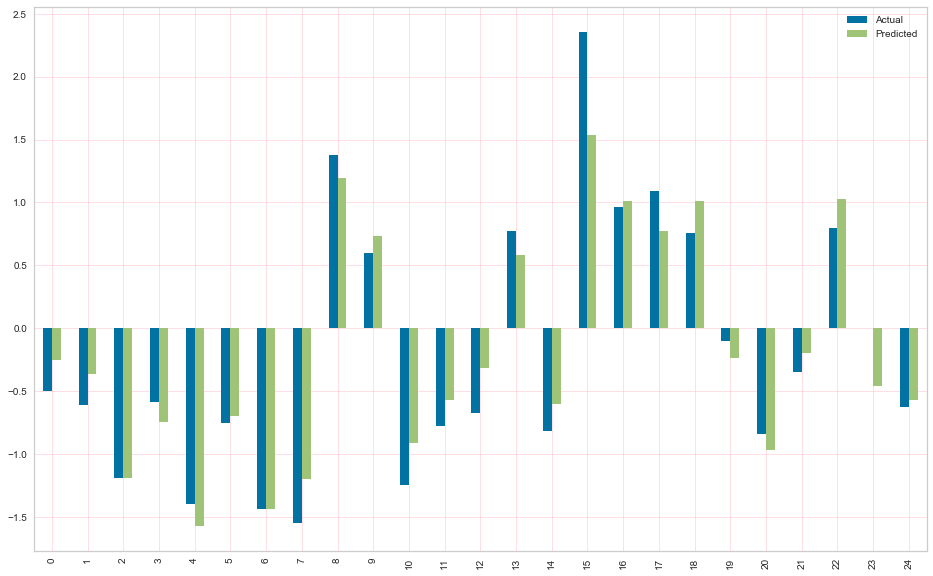

In [338]:
df2 = comparison.head(25)
df2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='pink')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [339]:
regr.score(X_train, y_train)

0.9145258405102556

## Best model selection

Make a table to compare these two models'accuracy

<table>
  <thead>
    <tr>
      <th>Comparative term: </th>
      <th>First Model </th>
      <th>Second Model</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Accuracy</td>
      <th>0.9291242333448995</th>
      <th>0.9145258405102556</th>
    </tr>
  </tbody>
</table>

The table shows the first model gives a better accuracy using the same value of k for K-folds, therefore, my preferred model is the first linear regression model I constructed.

## Conclusion:

1. From exploratory Data Analysis part, I found the dataset has no missing data, all variables are numeric including response variable.

2. From correlation heatmap, I found Temperature and Exhaust Vacuum have the strong correlation with Net hourly electrical energy output. Also, from scattor plots I also saw these two variables have some linear relatonships with Net hourly electrical energy output. These two variables became my ideal explanatory variables for constructing linear regression models.

3. Through Wrapper method to choose features, I found all the variables are significant to be regressors in linear regression model (with p-values less than 0.05), therefore, all sets of variables became another ideal explanatory variables I will select to construct the linear regression model.

4. I constructed two linear regression models, the first model is using variables Temperature, Exhaust Vacuum, Relative Humidity and Ambient Pressure as regressors, the second model is using variables Temperature and Exhaust Vacuum.

5. After calculating the sample size of the data, I choose k = 2 to be K-fold value to cross validate data, because it is a divisor of sample size, also small enough.

6. Using the same k value, I found the accuracy of the first linear regression model is greater than the accuracy of the second linear regression model, that may because the first model has two additional significant regressors.

7. Therefore, the first linear regression model with explanatory variables Temperature, Exhaust Vacuum, Relative Humidity and Ambient Pressure is my "preferred" model in this assignment.

Thanks for reading !

### [Video Link is here](https://screencast-o-matic.com/watch/cYjonrG5kI)